In [1]:
# Import essential libraries
import pandas as pd
import polars as pl

import dask.dataframe as dd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re

In [2]:
# Set visualization style
sns.set_theme(style="whitegrid")

# Define the path to your dataset
data_path = "../data/raw/complaints.csv" 

# Load the dataset
df = pd.read_csv(data_path, low_memory=False)


# Preview the shape and first few rows
print("Shape of the dataset:", df.shape)
df.head()

Shape of the dataset: (1048575, 18)


,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,20/06/2025,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,Experian Information Solutions Inc.,FL,32092,NaN,NaN,Web,20/06/2025,In progress,Yes,NaN,14195687.0
1,20/06/2025,Debt collection,Telecommunications debt,Attempts to collect debt not owed,Debt is not yours,NaN,Company can't verify or dispute the facts in t...,"Eastern Account Systems of Connecticut, Inc.",FL,342XX,NaN,NaN,Web,20/06/2025,Closed with explanation,Yes,NaN,14195688.0
2,20/06/2025,Credit reporting or other personal consumer re...,Credit reporting,Improper use of your report,Reporting company used your report improperly,NaN,NaN,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",AZ,85225,NaN,NaN,Web,20/06/2025,In progress,Yes,NaN,14195689.0
3,20/06/2025,Credit reporting or other personal consumer re...,Credit reporting,Improper use of your report,Reporting company used your report improperly,NaN,NaN,Experian Information Solutions Inc.,AZ,85225,NaN,NaN,Web,20/06/2025,In progress,Yes,NaN,14195690.0
4,20/06/2025,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Account status incorrect,NaN,NaN,Experian Information Solutions Inc.,IL,60628,NaN,NaN,Web,20/06/2025,In progress,Yes,NaN,14195692.0


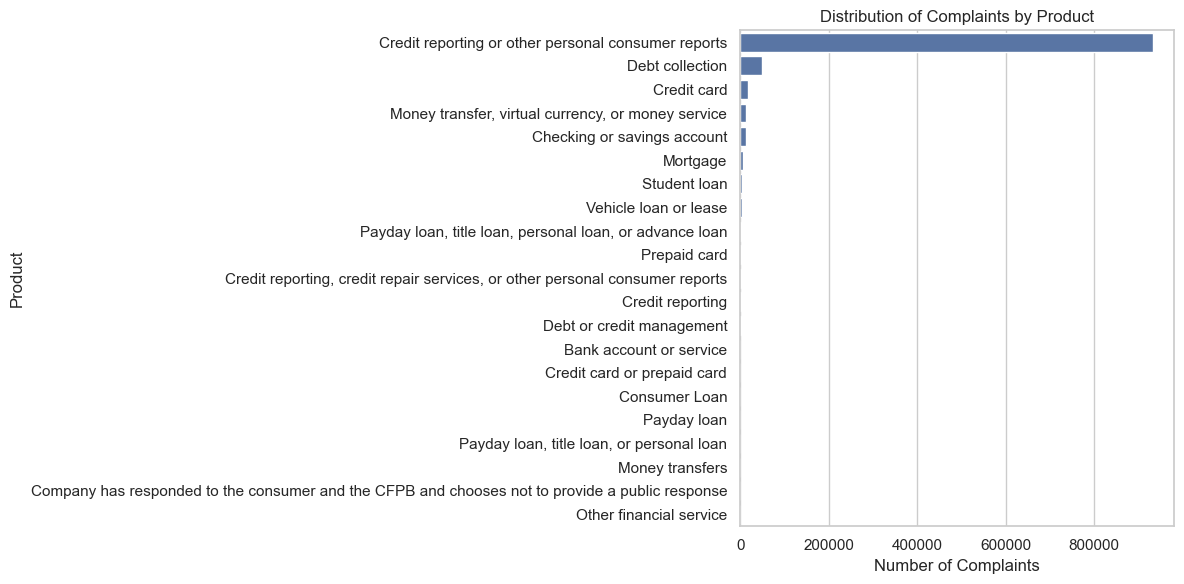

In [3]:
# Plot distribution of complaints by Product
plt.figure(figsize=(12, 6))
sns.countplot(data=df, y="Product", order=df["Product"].value_counts().index)
plt.title("Distribution of Complaints by Product")
plt.xlabel("Number of Complaints")
plt.ylabel("Product")
plt.tight_layout()
plt.show()

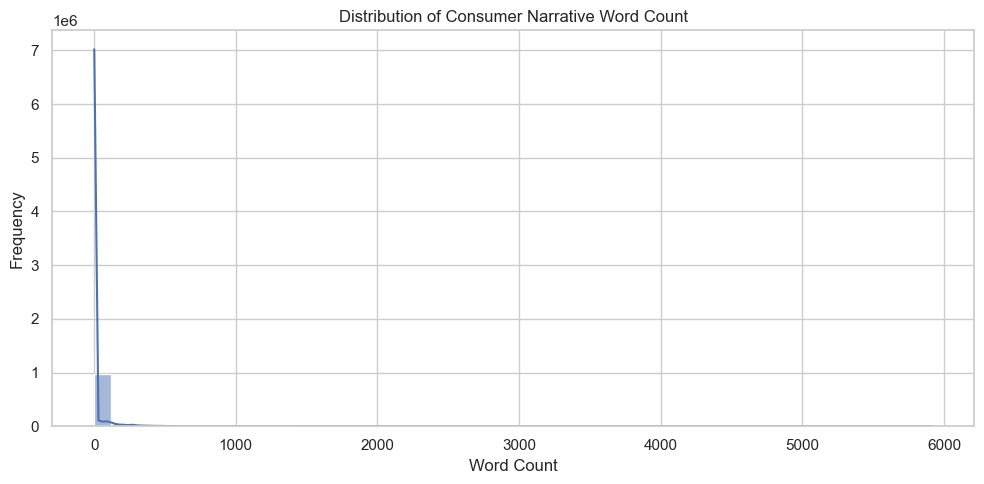

In [4]:
#Analyze Narrative Length
# Calculate number of words in each narrative
df["Narrative_Word_Count"] = df["Consumer complaint narrative"].astype(str).apply(lambda x: len(x.split()))

# Plot histogram of narrative lengths
plt.figure(figsize=(10, 5))
sns.histplot(df["Narrative_Word_Count"], bins=50, kde=True)
plt.title("Distribution of Consumer Narrative Word Count")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

In [5]:
# Count entries with and without complaint narrative
with_narrative = df["Consumer complaint narrative"].notna().sum()
without_narrative = df.shape[0] - with_narrative

print("Complaints with narrative:", with_narrative)
print("Complaints without narrative:", without_narrative)


Complaints with narrative: 159023
Complaints without narrative: 889552


In [6]:
# Filter to 5 target products & Non empty narratives
# Define the five products we care about
target_products = [
    "Credit card",
    "Personal loan",
    "Buy Now, Pay Later (BNPL)",
    "Savings account",
    "Money transfers"
]

# Filter by product and non-empty narrative
filtered_df = df[df["Product"].isin(target_products)]
filtered_df = filtered_df[filtered_df["Consumer complaint narrative"].notna()]
filtered_df = filtered_df[filtered_df["Consumer complaint narrative"].str.strip() != ""]

# Check result
print("Filtered dataset shape:", filtered_df.shape)
filtered_df[["Product", "Consumer complaint narrative"]].head()


Filtered dataset shape: (5018, 19)


,Product,Consumer complaint narrative
12237,Credit card,A XXXX XXXX card was opened under my name by a...
13280,Credit card,"Dear CFPB, I have a secured credit card with c..."
13506,Credit card,I have a Citi rewards cards. The credit balanc...
13955,Credit card,b'I am writing to dispute the following charge...
14249,Credit card,"Although the account had been deemed closed, I..."


In [7]:
#clean the narrative text
# Function to clean narrative text
def clean_text(text):
    text = text.lower()  # Lowercase
    text = re.sub(r"i am writing.*?complaint.*?\\b", "", text)  # Remove boilerplate
    text = re.sub(r"[^a-zA-Z0-9\\s]", "", text)  # Remove special characters
    text = re.sub(r"\\s+", " ", text).strip()  # Remove extra spaces
    return text

# Apply cleaning
filtered_df["Cleaned_Narrative"] = filtered_df["Consumer complaint narrative"].apply(clean_text)

# Preview cleaned narratives
filtered_df[["Product", "Cleaned_Narrative"]].head()


,Product,Cleaned_Narrative
12237,Credit card,axxxxxxxxcardwasopenedundermynamebyafraudsteri...
13280,Credit card,dearcfpbihaveasecuredcreditcardwithcitibankwhi...
13506,Credit card,ihaveacitirewardscardsthecreditbalanceissuedto...
13955,Credit card,biamwritingtodisputethefollowingchargesonmycit...
14249,Credit card,althoughtheaccounthadbeendeemedclosedicontinue...


In [9]:
# Save cleaned and filtered data
filtered_df.to_csv("../data/filtered_complaints.csv", index=False)
print("Cleaned dataset saved to: data/filtered_complaints.csv")


Cleaned dataset saved to: data/filtered_complaints.csv
